# Lab2B: Dynamic Computational Graphs

How different are computation in PyTorch from numpy? One main difference is that PyTorch constructs a computational network as it executes. The computation network allows for  backpropagation where the gradients are computed, thus allowing us to update the parameter values. In this session, we shall learn how PyTorch works under the hood.

#### Objectives:

1. Learn how to perform forward propagation
2. Learn how to perform backward propagation
3. Understand how forward propagation builds a dynamic computational graph in PyTorch
4. Understand how backward propagation computes the gradient and destroys the dynamic computational graph

#### Content:
1. [Computational Graph](#1.-Computational-Graph)
2. [Forward Propagation](#2.-Forward-Propagation)
3. [Backpropagation](#3.-Backpropagation)
   1. [The requires_grad attribute](#A.-The-requires_grad-attribute)
   2. [Backward Pass](#B.-Backward-Pass)
   3. [Beware: Backpropagation accumulates and not refreshes the gradients](#C.-Beware:-Backpropagation-accumulates-and-not-refreshes-the-gradients)
   4. [Explicit assignment creates additional node](#D.-Explicit-assignment-creates-additional-node)
   5. [PyTorch .detach method](#E.-PyTorch-.detach-method)
4. [Exercise](#Exercise)

In this tutorial, we shall visualize the computed computational graph using `torchviz` which is a wrapper for the `graphviz` library. The following code install `torchviz` for Colab. For windows, you need to also install [graphviz](https://graphviz.org/download/) and add the application to the system path.

In [ ]:
!pip install torchviz

In [ ]:
import torch
from torchviz import make_dot

---
## 1. Computational Graph

Different from *numpy* computations, a *deep learning framework* such as *TensorFlow* and *PyTorch* constructs a **computational network** as it executes. The computational graph can be used to compute the **gradient** of the parameters, which in turn is used by the **Gradient Descent** algorithm to update the model parameters. The gradient descent algorithm is an **iterative** process that iterates between the following two steps:
1. **forward** propagation computes the predicted output of the training sample and the **loss** function $L$
2. **backward** propagation computes the **gradient** of the parameters $\frac{dL}{dw_i}$

---
## 2. Forward Propagation

### PyTorch is based on **Dynamic** Network
PyTorch builds the computational graph under the hood *on the fly* as you code. This makes PyTorch very pythonic and easy to debug. 

Let's see what is meant by dynamic network computation by implementing the following codes.
<p></p>
<center>
    $$i2h = W_x.x\tag{1}$$    
</center>
<center>
    $$h2h = W_h.h$\tag{2}$$      
</center>
<center>
    $$next\_h^{(a)} = i2h + h2h$\tag{3}$$     
</center>
<center>
    $$next\_h^{(t)} = \tanh (next\_h^{(a)})$\tag{4}$$  
</center>
<center>
    $$out^{(t)} = \sum_i next\_h_i^{(t)}$\tag{5}$$  
</center>

where:
* the parameters $W_x$ and $W_h$ are *random* tensors of size (3,2) and (3,3), respective
* the input $x$ and $h$ are *random* tensors of size (2,1) and (3,1), respectively. 
* the intermediate tensors $i2h$, $h2h$ and $next\_h$ are tensors of size (3,1)
* the output $out$ is a scalar


First, let's initialize `Wh`, `Wx`, `x` and `h`. For `Wh` and `Wx`, we set its `requires_grad=True` to indicate that we wish to compute their gradients when we perform backpropagation later. The resultant computional graph are as follows:

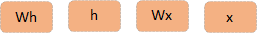

In [ ]:
# Initialize Wh, Wx, x, h
Wh = torch.randn(3,3, requires_grad=True)
Wx = torch.randn(3,2, requires_grad=True)
x  = torch.randn(2,1)
h  = torch.randn(3,1)

print('Wh:\n', Wh)
print('Wx:\n', Wx)
print('x:\n', x)
print('h:\n', h)

Wh:
 tensor([[-0.0382,  0.3588,  0.9098],
        [ 0.1079,  0.9366,  0.7766],
        [ 1.7196, -0.3527, -0.9506]], requires_grad=True)
Wx:
 tensor([[-0.0554, -1.2501],
        [-0.5647,  0.1148],
        [-1.9937, -0.6182]], requires_grad=True)
x:
 tensor([[-0.8152],
        [ 1.6714]])
h:
 tensor([[ 0.9817],
        [ 0.4191],
        [-1.7654]])


The following code computes `i2h` and `h2h`. The computational graph is updated and looks like this now:

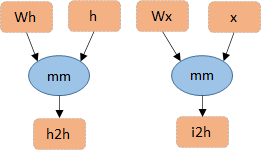

In [ ]:
# compute i2h and h2h
i2h = Wx.mm(x)
h2h = Wh.mm(h)

print('i2h:\n', i2h)
print('h2h:\n', h2h)

i2h:
 tensor([[-2.0443],
        [ 0.6522],
        [ 0.5921]], grad_fn=<MmBackward>)
h2h:
 tensor([[-1.4933],
        [-0.8725],
        [ 3.2184]], grad_fn=<MmBackward>)


In [ ]:
# add i2h and h2h
next_h = i2h + h2h
print('next_h:\n', next_h)

next_h:
 tensor([[-3.5376],
        [-0.2202],
        [ 3.8106]], grad_fn=<AddBackward0>)


The following code subjects `next_h` to tanh and name the output as `next_h`. The computational graph is updated as follows. Note that the old `next_h` node is now *unnamed* and the output of tanh assume the name `next_h`.

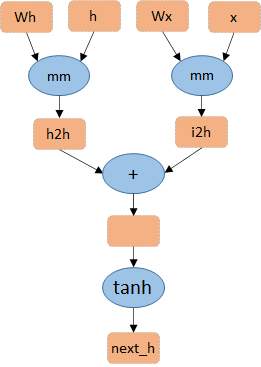


In [ ]:
# apply tanh
next_h = next_h.tanh()
print('next_h:\n', next_h)

next_h:
 tensor([[-0.9983],
        [-0.2167],
        [ 0.9990]], grad_fn=<TanhBackward>)


Now, sum all the items in vector `next_h` and store the output as `out`.

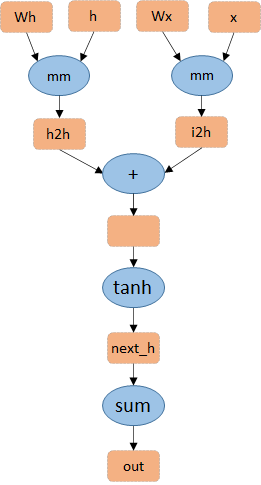

In [ ]:
# sum all items in next_h
out    = next_h.sum()
print('out:\n', out)

out:
 tensor(-0.2160, grad_fn=<SumBackward0>)


The following code uses graphviz to plot the computational graph

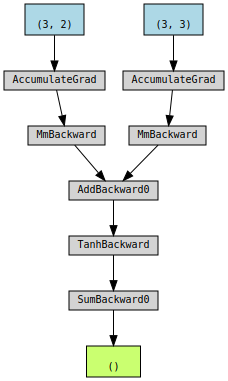

In [ ]:
make_dot(out)

---
# 3. Backpropagation

In the gradient descent algorithm, the forward propagation is always followed by backpropagation. The purpose of backpropagation is to **compute the gradient of some signal** with respect to the output. 


### A. The `requires_grad` attribute

To compute the gradient of a particular signal, e.g., $\frac{dout}{dW_h}$ and $\frac{dout}{dW_x}$, we must set their `requires_grad` attributes to `True`. Recall that we have already done so for `Wh` and `Wx`.

```
Wh = torch.randn(3,3, requires_grad=True)
Wx = torch.randn(3,2, requires_grad=True)
x  = torch.randn(2,1)
h  = torch.randn(3,1)
```

The `requires_grad` attribute is **contagious**. For a mathematical operations during forward propagation, if any one of the input tensor is set to `requires_grad=True`, then the generated output tensor will by default be set to `requires_grad=True`. 

The following diagram shows the values of `requires_grad` of all the tensors in the computational graph.

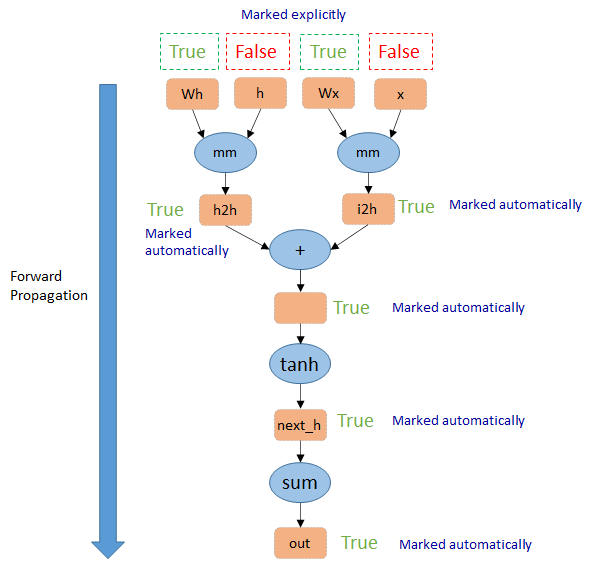

In [ ]:
print('Wh: requires_grad =', Wh.requires_grad)
print('Wx: reqauires_grad =', Wx.requires_grad)
print('h: requires_grad =',  h.requires_grad)
print('x: requires_grad =',  x.requires_grad)
print('i2h: requires_grad =', i2h.requires_grad)
print('h2h: requires_grad =', h2h.requires_grad)
print('next_h: requires_grad =', next_h.requires_grad)
print('out: requires_grad =', out.requires_grad)

Wh: requires_grad = True
Wx: reqauires_grad = True
h: requires_grad = False
x: requires_grad = False
i2h: requires_grad = True
h2h: requires_grad = True
next_h: requires_grad = True
out: requires_grad = True


---

### B. Backward Pass

We perform backward propagation from the signal that we want to differentiate. For example, referring to figure 1, backpropagating from $out$ gives us $\frac{dout}{dW_h}$ and $\frac{dout}{dWx}$.

In [ ]:
out.backward()

Backpropagation helps us to compute $\frac{dout}{dW_x}$ and $\frac{dout}{W_h}$ which we have set `requires_grad=True`.

In [ ]:
print('gradient of Wx:\n',Wx.grad)
print('\ngradient of Wh:\n', Wh.grad)

gradient of Wx:
 tensor([[-0.0028,  0.0056],
        [-0.7770,  1.5929],
        [-0.0016,  0.0033]])

gradient of Wh:
 tensor([[ 3.3156e-03,  1.4155e-03, -5.9624e-03],
        [ 9.3559e-01,  3.9941e-01, -1.6824e+00],
        [ 1.9222e-03,  8.2059e-04, -3.4566e-03]])


The gradients for other tensors are not available:
* The values of $\frac{dout}{dx}$ and $\frac{dout}{dh}$ are not available since their `requires_grad=False`.
* The gradients of **intermediate** (non-leaf) nodes such as $i2h$, $h2h$ and $next\_h$ are also not available. This is because all the intermediate variables' gradient are **removed** during the `backward()` call. If you want to retain those gradients, call `i2h.retain_grad()`, `h2h.retain_grad()` and `next_h.retain_grad` before calling `backward()`.

In [ ]:
# requires_grad set to False
print('gradient of x:', x.grad)
print('gradient of h:', h.grad)

# removed during backpropagation
print('gradient of i2h:', i2h.grad)
print('gradient of h2h:', h2h.grad)
print('gradient of next_h:', next_h.grad)

gradient of x: None
gradient of h: None
gradient of i2h: None
gradient of h2h: None
gradient of next_h: None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  """
/usr

When you call `out.backward()`, as the gradients are computed, these buffers (for non-leaf variables) are essentially freed, and the graph is destroyed leaving only the tensors intact. In other words, once you call `out.backward`, **the graph is destroyed**. 

Hence, you cannot call `out.backward()` twice.

In [ ]:
out.backward()     # this will generate an error

---

### C. Beware: Backpropagation accumulates and not refreshes the gradients

PyTorch does **not overwrite** the gradient each time you compute the gradient. Rather, it **accumulates** the gradient of the tensors that we have set `requires_grad=True`. The following code makes this point. First, let's monitor the gradient of $W_h$ when we perform forward and backpropagation multiple times. We shall set $W_h$, $W_x$, $h$ and $x$ to a constant so that the gradient in each iterations are predictable and remains the same

In [ ]:
Wh = torch.ones(3,3, requires_grad=True)
Wx = torch.zeros(3,2)
x  = torch.ones(2,1)
h  = torch.ones(3,1)

def forward():
    i2h = Wx.mm(x)
    h2h = Wh.mm(h)
    next_h = i2h + h2h
    next_h = next_h.tanh()
    out    = next_h.sum()
    return out

Each time we perform forward and backpropagation, the gradient will be accumulated rather than refreshed.

In [ ]:
for i in range(3):
    out = forward()  # forward propagation
    out.backward()    # backpropagation
    print(f'Iter {i}:', Wh.grad.flatten())

Iter 0: tensor([0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099])
Iter 1: tensor([0.0197, 0.0197, 0.0197, 0.0197, 0.0197, 0.0197, 0.0197, 0.0197, 0.0197])
Iter 2: tensor([0.0296, 0.0296, 0.0296, 0.0296, 0.0296, 0.0296, 0.0296, 0.0296, 0.0296])


To **refresh** the gradient in each iteration without accummulating, we need to reset the gradients to zero. This is done through the following command:

`Wh.grad.zero_()`

In the following, we reset the gradients to zero each time before forward and backward propagation. Since the input to the network remains unchanged for all iterations, as expected, we get the same gradient in all iterations.

In [ ]:
for i in range(3):
    Wh.grad.zero_()
    out = forward()
    out.backward()
    print('Iter', i, ':', Wh.grad.flatten())

Iter 0 : tensor([0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099])
Iter 1 : tensor([0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099])
Iter 2 : tensor([0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099])


---
### D. Explicit assignment creates additional node

Remember that the operations in PyTorch is creating a computational graph. Hence, when you update a variable, it is not as simple as replacing the variable itself.

1. $y = x_1*w_1$
2. $y = y*w_2$
3. $out = y^2$

Rather than **replacing** the content of y, it actually creates a **new node** in the computational graph as shown below:

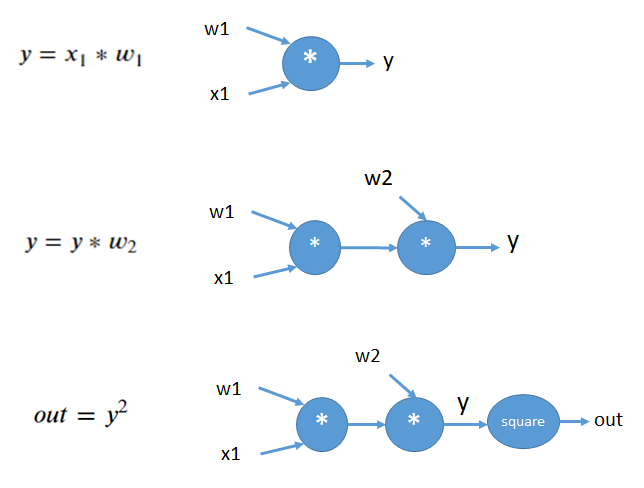

So, when you perform backpropagation and compute `dy`, you are actually computing the gradient of most recent (last) node assigned with the label `y`. 

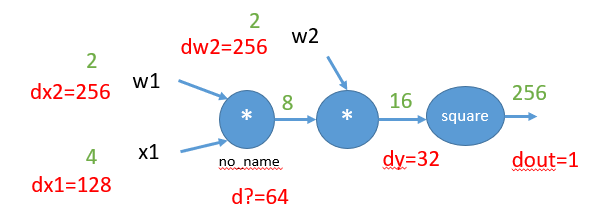


In [ ]:
w1 = torch.tensor(2., requires_grad=True)
w2 = torch.tensor(2., requires_grad=True)
x  = torch.tensor(4., requires_grad=True)
y = w1*x
y = w2*y
y.retain_grad()
out = y**2

The following code shows that the gradients  of `dy = 32` not `64`. 

In [ ]:
out.backward()
print('dy=', y.grad)

dy= tensor(32.)


---
### E. Inplace operation in PyTorch

If you want to simply update the same node **without creating a new node**, then you should should **inplace** operation.

To perform in-place operation, you can use the following two syntax:

So, rather than performing 

`x = x - 10` 

which creates a new node in the computational graph, you can perform

`x.mult_(10)`

or

`x -= 10`

which will update the same node.

But be careful, in-place oepration may affect the backpropagation if not appropriately used. Therefore, in-place operation is normally used to update model parameters which are leaf nodes in the computational graphs.



---
### F. PyTorch .detach method

Every single code that you write may affect the computational graph. To perform automatic differentiation, PyTorch keeps track of all operations involving tensors that needs gradient computation by constructing the computational graph.

However, in some situations, you may do some simple debugging or perform some operations on top of the signals for other signals. In this case, you do not want these code to affect your computational graph. To do so, you may use:

`Tensor.detach()` 

* Creates a new **view** of  of the tensor. 
* The tensor will be excluded from the tracking operations and this will not be recorded in the computational 

If you want to get a detached **copy** of the tensor, then you may use

`Tensor.detach().clone()`

Example:

Consider the following code:

In [ ]:
x = torch.ones(10, requires_grad=True)
y=x**2
z=x**3
out=(y+z).sum()

The generated computational graph looks as follows:

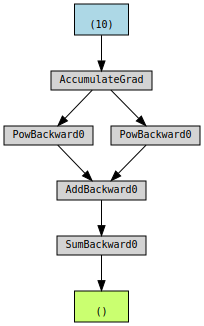

In [ ]:
make_dot(out)
# make_dot(out).render("output_graph", format="png") save the computational graph as "output_graph.png"

If we create a *detached* view of `x` when creating the tensor `z`, then `z` would not be used to construct the computational graph and subsequent operation on `z` will not be tracked. Let's do that in the following code. 

Compare the newly new computational graph compared to the one above. It will now omit `z`.

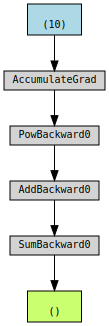

In [ ]:
x = torch.ones(10, requires_grad=True)
y=x.detach()**2
z=x**3
out=(y+z).sum()

make_dot(out)

---
<font color="blue">

### Exercise 
    
Implement the following operations:

$$f(x,y,z) = (x^2 + y)z$$

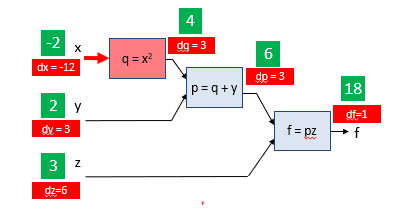
    
Expected ans:
```
df/dx = -12.0
df/dy = 3.0
df/dz = 6.0
df/dp = 3.0
df/dq = 3.0
```

In [ ]:
### START CODE HERE ###

# initialize x, y, z (3 lines)

# forward propate (1-3 lines)

# retain gradient for p and q (2 lines)

# perform backpropagation (1line)

### END CODE HERE ###

print('df/dx =', x.grad.item())
print('df/dy =', y.grad.item())
print('df/dz =', z.grad.item())
print('df/dp =', p.grad.item())
print('df/dq =', q.grad.item())

<center> --- End of Lab02B --- </center>